In [1]:
import datetime
import math
import pandas as pd
import numpy as np
import pandas_datareader.data as data
from pandas.plotting import scatter_matrix
from pandas import Series, DataFrame
import copy

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl

In [2]:
# setting the timeframe for our data
past = datetime.datetime(2015, 1, 1)
present = datetime.datetime(2020, 4, 25)

# Yahoo API google finance data
google = data.DataReader("GOOG", 'yahoo', start=past, end=present)
google.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-04-20,1281.599976,1261.369995,1271.000000,1266.609985,1695500.0,1266.609985
2020-04-21,1254.270020,1209.709961,1247.000000,1216.339966,2153000.0,1216.339966
2020-04-22,1285.613037,1242.000000,1245.540039,1263.209961,2093100.0,1263.209961
2020-04-23,1293.310059,1265.670044,1271.550049,1276.310059,1566200.0,1276.310059
2020-04-24,1280.400024,1249.449951,1261.170044,1279.310059,1639600.0,1279.310059


In [3]:
# moving average mean of closing data for past 6 months
googleClose = google['Adj Close']
avgMean = googleClose.rolling(window=180).mean()

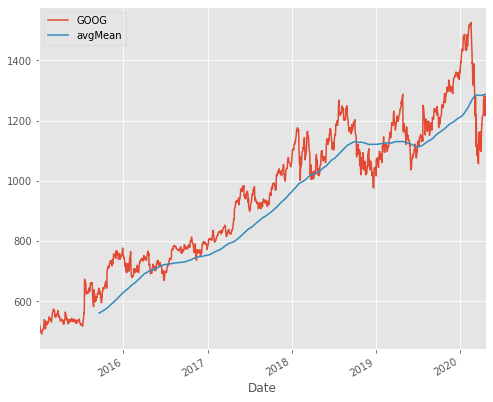

In [4]:
# matplotlib plot of Google data
mpl.rc('figure', figsize=(8, 7))
mpl.__version__


style.use('ggplot')
googleClose.plot(label='GOOG')
avgMean.plot(label='avgMean')
plt.legend()

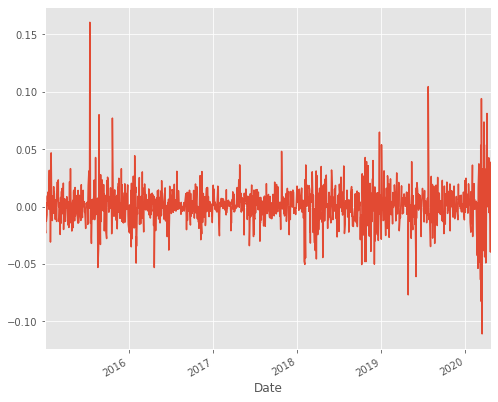

In [5]:
# returns
returns = googleClose / googleClose.shift(1) - 1
returns.plot(label='return')

In [6]:
# Yahoo finance API data 
df = data.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=past,end=present)
df.tail()

Attributes   Adj Close                                                  Close  \
Symbols           AAPL    GE         GOOG         IBM        MSFT        AAPL   
Date                                                                            
2020-04-20  276.929993  6.51  1266.609985  120.410004  175.059998  276.929993   
2020-04-21  268.369995  6.48  1216.339966  116.760002  167.820007  268.369995   
2020-04-22  276.100006  6.43  1263.209961  119.309998  173.520004  276.100006   
2020-04-23  275.029999  6.52  1276.310059  121.349998  171.419998  275.029999   
2020-04-24  282.970001  6.26  1279.310059  124.720001  174.550003  282.970001   

Attributes                                             ...        Open        \
Symbols       GE         GOOG         IBM        MSFT  ...        AAPL    GE   
Date                                                   ...                     
2020-04-20  6.51  1266.609985  120.410004  175.059998  ...  277.950012  6.61   
2020-04-21  6.48  1216.339966  116.760002  167.820007  ...  276.279999  6.39   
2020-04-22  6.43  1263.209961  119.309998  173.520004  ...  273.609985  6.59   
2020-04-23  6.52  1276.310059  121.349998  171.419998  ...  275.869995  6.46   
2020-04-24  6.26  1279.310059  124.720001  174.550003  ...  277.200012  6.59   

Attributes                                           Volume               \
Symbols            GOOG         IBM        MSFT        AAPL           GE   
Date                                                                       
2020-04-20  1271.000000  119.150002  176.630005  32503800.0   99691600.0   
2020-04-21  1247.000000  114.000000  173.500000  45247900.0   77453100.0   
2020-04-22  1245.540039  119.870003  171.389999  29264300.0   76844100.0   
2020-04-23  1271.550049  119.570000  174.110001  31203600.0   82796100.0   
2020-04-24  1261.170044  122.410004  172.059998  31540300.0  155616400.0   

Attributes                                     
Symbols          GOOG         IBM        MSFT  
Date                                           
2020-04-20  1695500.0   8181700.0  36669600.0  
2020-04-21  2153000.0  14349000.0  56203700.0  
2020-04-22  2093100.0   7087900.0  34651600.0  
2020-04-23  1566200.0   6881600.0  32790800.0  
2020-04-24  1639600.0   4985900.0  34277600.0  

[5 rows x 30 columns]

In [7]:
df = data.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=past,end=present)['Adj Close']
df.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2020-04-20,276.929993,6.51,1266.609985,120.410004,175.059998
2020-04-21,268.369995,6.48,1216.339966,116.760002,167.820007
2020-04-22,276.100006,6.43,1263.209961,119.309998,173.520004
2020-04-23,275.029999,6.52,1276.310059,121.349998,171.419998
2020-04-24,282.970001,6.26,1279.310059,124.720001,174.550003


In [8]:
# correlation plot
correlation = df.pct_change()
corr = correlation.corr()
corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.419746,0.622501,0.529123,0.683591
GE,0.419746,1.000000,0.390769,0.490258,0.424623
GOOG,0.622501,0.390769,1.000000,0.524424,0.727862
IBM,0.529123,0.490258,0.524424,1.000000,0.591999
MSFT,0.683591,0.424623,0.727862,0.591999,1.000000


Text(0, 0.5, 'Microsoft Returns')

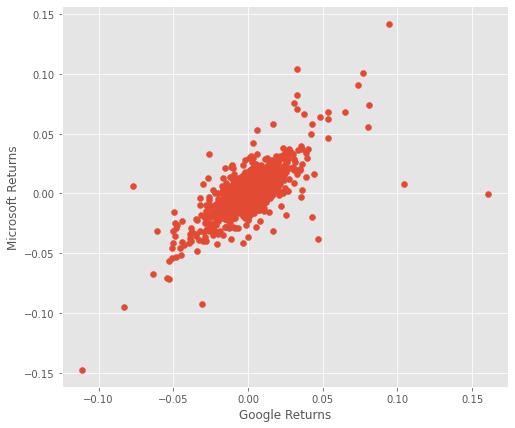

In [9]:
plt.scatter(correlation.GOOG, correlation.MSFT)
plt.xlabel('Google Returns')
plt.ylabel('Microsoft Returns')

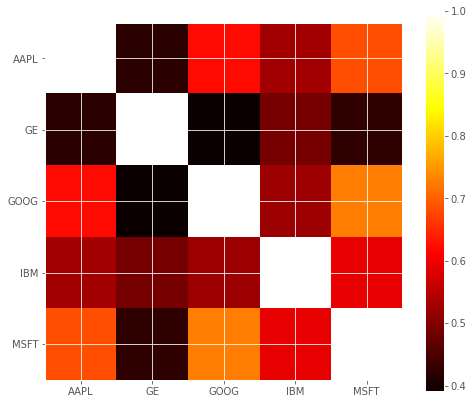

In [10]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

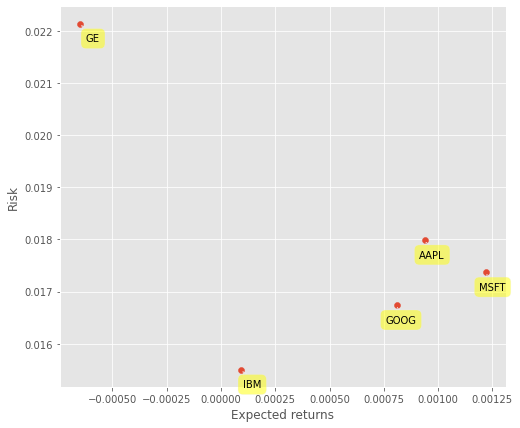

In [11]:
plt.scatter(correlation.mean(), correlation.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(correlation.columns, correlation.mean(), correlation.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [12]:
google.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-04-20,1281.599976,1261.369995,1271.000000,1266.609985,1695500.0,1266.609985
2020-04-21,1254.270020,1209.709961,1247.000000,1216.339966,2153000.0,1216.339966
2020-04-22,1285.613037,1242.000000,1245.540039,1263.209961,2093100.0,1263.209961
2020-04-23,1293.310059,1265.670044,1271.550049,1276.310059,1566200.0,1276.310059
2020-04-24,1280.400024,1249.449951,1261.170044,1279.310059,1639600.0,1279.310059


In [13]:
dfFeat = google.loc[:,['Adj Close','Volume']]
dfFeat['HL_PCT'] = (google['High'] - google['Low']) / google['Close'] * 100.0
dfFeat['PCT_change'] = (google['Close'] - google['Open']) / google['Open'] * 100.0

In [14]:
dfFeat.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2020-04-20,1266.609985,1695500.0,1.597175,-0.345398
2020-04-21,1216.339966,2153000.0,3.663454,-2.458704
2020-04-22,1263.209961,2093100.0,3.452556,1.418655
2020-04-23,1276.310059,1566200.0,2.165619,0.374347
2020-04-24,1279.310059,1639600.0,2.419279,1.438348


In [15]:
dfFeat.fillna(value=-99999, inplace=True)
# forecasting 20% of data and predicting the AdjCllose
forecast_col = 'Adj Close'
forecast_out = int(math.ceil(0.2 * len(dfFeat)))
dfFeat['label'] = dfFeat[forecast_col].shift(forecast_out)
dfFeat_noDrop = dfFeat
dfFeat.dropna(inplace=True)
dfFeat.tail()

,Adj Close,Volume,HL_PCT,PCT_change,label
Date,,,,,
2020-04-20,1266.609985,1695500.0,1.597175,-0.345398,1173.020020
2020-04-21,1216.339966,2153000.0,3.663454,-2.458704,1168.489990
2020-04-22,1263.209961,2093100.0,3.452556,1.418655,1173.310059
2020-04-23,1276.310059,1566200.0,2.165619,0.374347,1194.430054
2020-04-24,1279.310059,1639600.0,2.419279,1.438348,1200.489990


In [16]:
forecast_out

268

In [17]:
X = np.array(dfFeat.drop(['label'],1))
y = np.array(dfFeat['label'])
X = preprocessing.scale(X)
X_late = X[-forecast_out:]
y = np.array(dfFeat['label'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=2)

In [19]:
# Linear regression
linearReg = LinearRegression()
linearReg.fit(X_train, y_train)

y_predict = linearReg.predict(X_test)
accuracy = linearReg.score(X_test, y_test)

print("Prediction Accuracy: %.1f%%" % (accuracy * 100.0))

Prediction Accuracy: 75.9%


In [20]:
# KNN Regression
knnReg = KNeighborsRegressor(n_neighbors=3)
knnReg.fit(X_train, y_train)

y_predict = knnReg.predict(X_test)
accuracy = knnReg.score(X_test, y_test)

print("Prediction Accuracy: %.1f%%" % (accuracy * 100.0))

Prediction Accuracy: 73.0%


In [21]:
forecastStock = linearReg.predict(X_late)
dfFeat['Forecast'] = np.nan

In [22]:
dfFeat.tail()

,Adj Close,Volume,HL_PCT,PCT_change,label,Forecast
Date,,,,,,
2020-04-20,1266.609985,1695500.0,1.597175,-0.345398,1173.020020,NaN
2020-04-21,1216.339966,2153000.0,3.663454,-2.458704,1168.489990,NaN
2020-04-22,1263.209961,2093100.0,3.452556,1.418655,1173.310059,NaN
2020-04-23,1276.310059,1566200.0,2.165619,0.374347,1194.430054,NaN
2020-04-24,1279.310059,1639600.0,2.419279,1.438348,1200.489990,NaN


In [23]:
dfFeat.iloc[-1].name

Timestamp('2020-04-24 00:00:00')

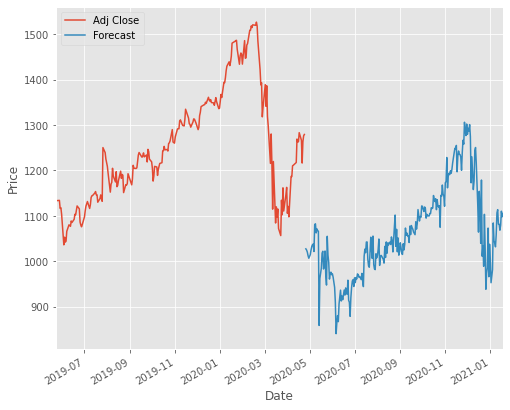

In [24]:
dateRecent = dfFeat.iloc[-1].name
nextCalc = dateRecent + datetime.timedelta(days=1)

for i in forecastStock:
    datePred = nextCalc
    nextCalc += datetime.timedelta(days=1)
    dfFeat.loc[nextCalc] = [np.nan for _ in range(len(dfFeat.columns)-1)]+[i]
dfFeat['Adj Close'].tail(500).plot()
dfFeat['Forecast'].tail(500).plot()
plt.legend(loc=2)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [25]:
# setting the timeframe for our data gathering
past = datetime.datetime(2020, 1, 1)
present = datetime.datetime(2020, 4, 25)

# Yahoo API google finance data
google = data.DataReader("GOOG", 'yahoo', start=past, end=present)
google.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-04-20,1281.599976,1261.369995,1271.000000,1266.609985,1695500,1266.609985
2020-04-21,1254.270020,1209.709961,1247.000000,1216.339966,2153000,1216.339966
2020-04-22,1285.613037,1242.000000,1245.540039,1263.209961,2093100,1263.209961
2020-04-23,1293.310059,1265.670044,1271.550049,1276.310059,1566200,1276.310059
2020-04-24,1280.400024,1249.449951,1261.170044,1279.310059,1639600,1279.310059


In [26]:
# moving average mean of closing data for past 6 months
googleClose = google['Adj Close']
avgMean = googleClose.rolling(window=180).mean()

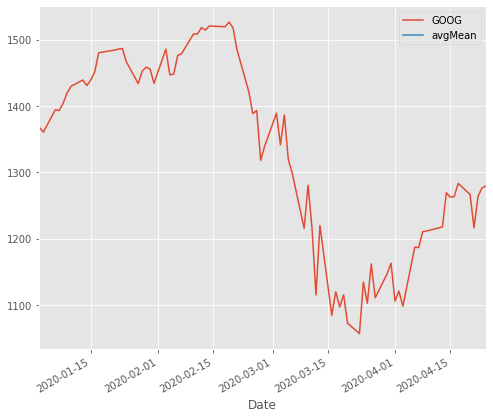

In [27]:
# matplotlib plot of Google data
mpl.rc('figure', figsize=(8, 7))
mpl.__version__


style.use('ggplot')
googleClose.plot(label='GOOG')
avgMean.plot(label='avgMean')
plt.legend()

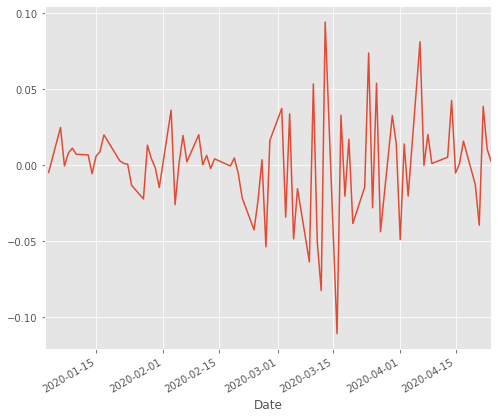

In [28]:
# returns
returns = googleClose / googleClose.shift(1) - 1
returns.plot(label='return')

In [29]:
df = data.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=past,end=present)
df.tail()

Attributes   Adj Close                                                  Close  \
Symbols           AAPL    GE         GOOG         IBM        MSFT        AAPL   
Date                                                                            
2020-04-20  276.929993  6.51  1266.609985  120.410004  175.059998  276.929993   
2020-04-21  268.369995  6.48  1216.339966  116.760002  167.820007  268.369995   
2020-04-22  276.100006  6.43  1263.209961  119.309998  173.520004  276.100006   
2020-04-23  275.029999  6.52  1276.310059  121.349998  171.419998  275.029999   
2020-04-24  282.970001  6.26  1279.310059  124.720001  174.550003  282.970001   

Attributes                                             ...        Open        \
Symbols       GE         GOOG         IBM        MSFT  ...        AAPL    GE   
Date                                                   ...                     
2020-04-20  6.51  1266.609985  120.410004  175.059998  ...  277.950012  6.61   
2020-04-21  6.48  1216.339966  116.760002  167.820007  ...  276.279999  6.39   
2020-04-22  6.43  1263.209961  119.309998  173.520004  ...  273.609985  6.59   
2020-04-23  6.52  1276.310059  121.349998  171.419998  ...  275.869995  6.46   
2020-04-24  6.26  1279.310059  124.720001  174.550003  ...  277.200012  6.59   

Attributes                                           Volume               \
Symbols            GOOG         IBM        MSFT        AAPL           GE   
Date                                                                       
2020-04-20  1271.000000  119.150002  176.630005  32503800.0   99691600.0   
2020-04-21  1247.000000  114.000000  173.500000  45247900.0   77453100.0   
2020-04-22  1245.540039  119.870003  171.389999  29264300.0   76844100.0   
2020-04-23  1271.550049  119.570000  174.110001  31203600.0   82796100.0   
2020-04-24  1261.170044  122.410004  172.059998  31540300.0  155616400.0   

Attributes                                     
Symbols          GOOG         IBM        MSFT  
Date                                           
2020-04-20  1695500.0   8181700.0  36669600.0  
2020-04-21  2153000.0  14349000.0  56203700.0  
2020-04-22  2093100.0   7087900.0  34651600.0  
2020-04-23  1566200.0   6881600.0  32790800.0  
2020-04-24  1639600.0   4985900.0  34277600.0  

[5 rows x 30 columns]

In [30]:
df = data.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=past,end=present)['Adj Close']
df.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2020-04-20,276.929993,6.51,1266.609985,120.410004,175.059998
2020-04-21,268.369995,6.48,1216.339966,116.760002,167.820007
2020-04-22,276.100006,6.43,1263.209961,119.309998,173.520004
2020-04-23,275.029999,6.52,1276.310059,121.349998,171.419998
2020-04-24,282.970001,6.26,1279.310059,124.720001,174.550003


In [31]:
# correlation plot
correlation = df.pct_change()
corr = correlation.corr()
corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.755043,0.915444,0.813823,0.934007
GE,0.755043,1.000000,0.754330,0.748085,0.751546
GOOG,0.915444,0.754330,1.000000,0.824655,0.922647
IBM,0.813823,0.748085,0.824655,1.000000,0.804250
MSFT,0.934007,0.751546,0.922647,0.804250,1.000000


Text(0, 0.5, 'Microsoft Returns')

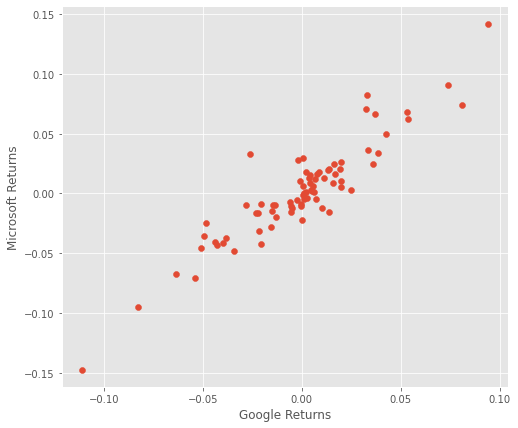

In [32]:
plt.scatter(correlation.GOOG, correlation.MSFT)
plt.xlabel('Google Returns')
plt.ylabel('Microsoft Returns')

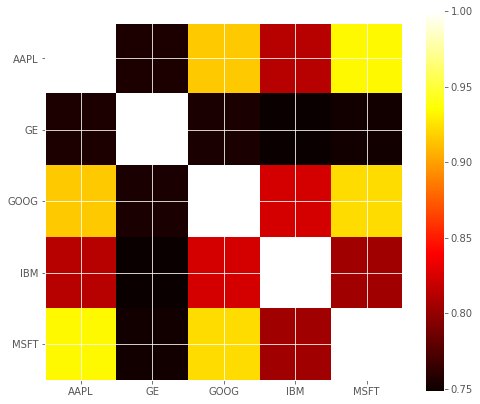

In [33]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

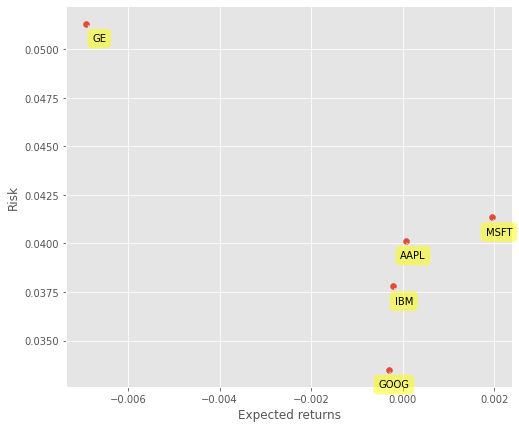

In [34]:
plt.scatter(correlation.mean(), correlation.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(correlation.columns, correlation.mean(), correlation.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))